<a href="https://colab.research.google.com/github/FarahYusri12/Warfarin_Dosing_Prediction-Model_Comparison/blob/main/Ridge_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv('Preprocessed_data.csv')
print(df.head())
print("\n" + "="*100 + "\n")
print(df.info())

            ID Age (years)  Gender  Weight (kg)  Height (cm)  Dose (mg)  \
0  PA135312261     60 - 69    Male        115.7       193.04       49.0   
1  PA135312262     50 - 59  Female        144.2       176.53       42.0   
2  PA135312263     40 - 49  Female         77.1       162.56       53.0   
3  PA135312264     60 - 69    Male         90.7       182.24       28.0   
4  PA135312265     50 - 59    Male         72.6       167.64       42.0   

  CYP2C9 VKORC1 (rs9923231; C/T)  Gender_code  CYP2C9_code  VKORC1_code   Age  
0  *1/*1                     A/G            1            0            1  64.5  
1  *1/*1                     A/A            0            0            2  54.5  
2  *1/*1                     G/G            0            0            0  44.5  
3  *1/*1                     A/G            1            0            1  64.5  
4  *1/*3                     A/G            1            1            1  54.5  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3419 entries, 0 t

In [2]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
#======================
# Data Preparation
#=====================

# separate data into 2 parts x and y
# x- data that will be used to make prediction
# y- the data variable to be predicted by the variable

x=df[["Age", "Gender_code", "Weight (kg)", "Height (cm)", "CYP2C9_code", "VKORC1_code"]]
y= df["Dose (mg)"]

# train test split
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.2, random_state=42)

In [4]:
#===================
# Model training
#==================

# Pipeline setup
pipeline=Pipeline([
    ('scaler', StandardScaler()), # to make sure all the features are on the same scale to prevent biased model (standardscaler)
    ('ridge', Ridge())
])

# model will learn from x_train and y_train to identify pattern and relationship between features and dose
# model will make prediction on x_test data and compare the actual value with y_test to see how accurate it is.
# 20% data will be used for testing and 80% for training (test_size=0.2)

In [5]:
# perform hyperparameter tuning for ridge regression

alphas_wide=np.logspace(-6, 6, 25)
param_grid= {'ridge__alpha': alphas_wide}

grid= GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

# Train model (1)
grid.fit(x_train, y_train)

print("Best alpha (wide):", grid.best_params_['ridge__alpha'])
print ("Best CV score (wide):", grid.best_score_)

# A wide search space of alpha values (10⁻⁶ to 10⁶) is tested using 5-fold cross-validation (cv=5)
# GridSearchCV automatically evaluates all candidate models and selects the alpha that gives the best R² score.

Best alpha (wide): 100.0
Best CV score (wide): 0.4293769870626297


In [6]:
alphas_narrow=np.logspace(1, 3, 20)
param_grid= {'ridge__alpha': alphas_narrow}

grid_narrow= GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

# Train model (2)
grid_narrow.fit(x_train, y_train)

print("Best alpha (narrow):", grid_narrow.best_params_['ridge__alpha'])
print ("Best CV score (narrow):", grid_narrow.best_score_)

# refine the search space to a narrower range (10¹ to 10³).

Best alpha (narrow): 69.51927961775606
Best CV score (narrow): 0.42943520649274436


In [7]:
#=============
# Evaluation
#=============

best_model=grid_narrow.best_estimator_
y_pred=best_model.predict(x_test)

mae=mean_absolute_error(y_test, y_pred)
mse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)

print("Model performance:")
print(f"Mae : {mae:.2f}")
print(f"Rmse: {mse:.2f}")
print(f"R2  : {r2:.2f}")

# The best Ridge model (selected from GridSearchCV) is evaluated on the test set

Model performance:
Mae : 8.67
Rmse: 12.26
R2  : 0.46


In [8]:
#=======================
# Permutation importance
#=======================

perm_importance=permutation_importance(
    best_model,
    x_test,
    y_test,
    n_repeats=30,
    random_state=42,
)

feature_important= pd.DataFrame ({
    'Feature':x_test.columns,
    'Importance_mean': perm_importance.importances_mean,
    'Importance_std': perm_importance.importances_std
}). sort_values(by='Importance_mean', ascending=False)
# make a DataFrame to keep features, mean and std

print("Feature importance:")
print(feature_important)

Feature importance:
       Feature  Importance_mean  Importance_std
5  VKORC1_code         0.409156        0.027073
0          Age         0.093536        0.011752
2  Weight (kg)         0.090776        0.014952
4  CYP2C9_code         0.086179        0.011316
3  Height (cm)         0.023418        0.007240
1  Gender_code         0.007807        0.004528


Visualization

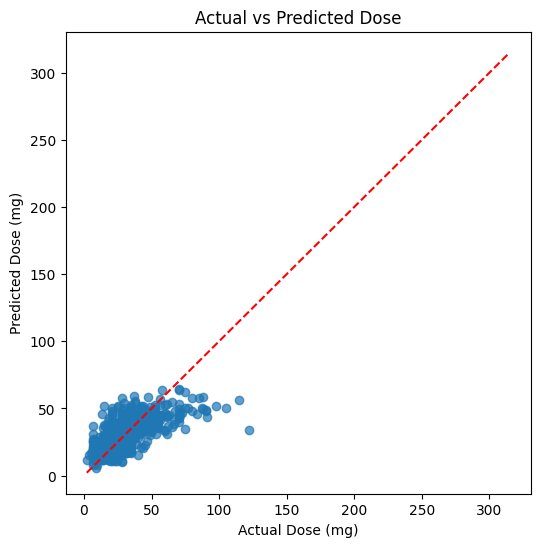

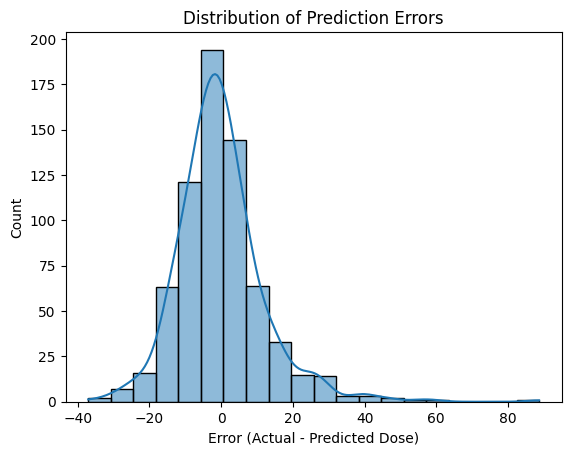

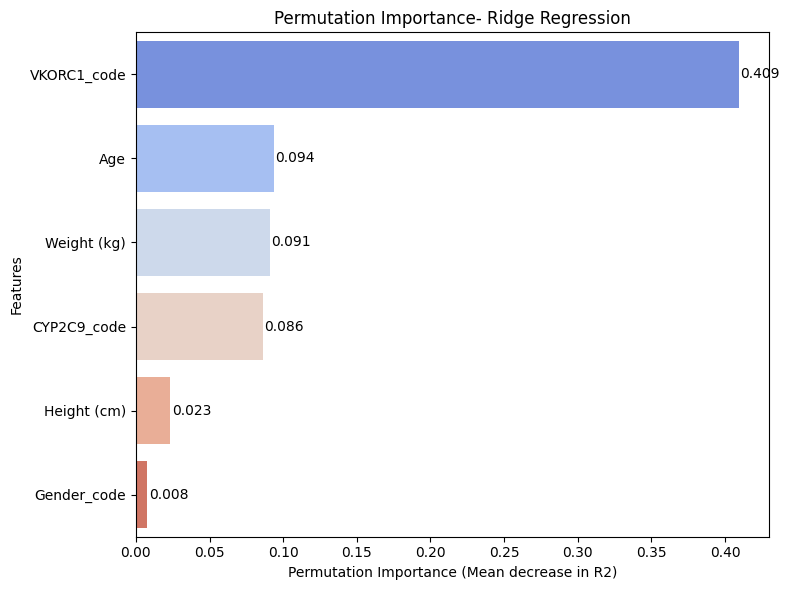

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# scatter Plot : Actual vs Predicted dose
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Dose (mg)")
plt.ylabel("Predicted Dose (mg)")
plt.title("Actual vs Predicted Dose")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")
plt.show()

print("\n" + "="*100 + "\n")

# Distribution plot error (sejauh mana prediction lari)
errors = y_test - y_pred

sns.histplot(errors, bins=20, kde=True)
plt.xlabel("Error (Actual - Predicted Dose)")
plt.title("Distribution of Prediction Errors")
plt.show()

print("\n" + "="*100 + "\n")

# Permutation importance bar plot

plt.figure(figsize=(8,6))
ax=sns.barplot(
    x="Importance_mean",
    y="Feature",
    data=feature_important,
    hue="Feature",
    palette="coolwarm",
    legend=False,
    )
plt.xlabel("Change in MAE value")
plt.ylabel("Features")
plt.title("Permutation Feature Importance(Ridge Regression)")

for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", padding=1)
# add value in each bar

plt.tight_layout()
plt.show()

In [11]:
result={
    'Model':'Ridge Regression',
    'R2': r2,
    'MAE':mae,
    'RMSE':mse
}
pd.DataFrame([result]).to_csv('Ridge_Regression_result.csv', index=False)
print('done')

done


In [10]:
feature_important.to_csv('Ridge_Regression_perm_importance.csv', index=False)
print('done')

done
